<a href="https://colab.research.google.com/github/phoenixfin/deeplearning-notebooks/blob/main/Air_Quality_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction

---

Aditya Firman Ihsan


## Persiapan

### Import library

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
tf.__version__

'2.3.0'

### Mengunduh dataset


Dataset diunduh langsung dari [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data) berupa data kualitas udara di Beijing pada 2013-2017 yang disediakan oleh Zhang, dkk. 


---


Referensi Paper:

> Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X. (2017) Cautionary Tales on Air-Quality Improvement in Beijing. Proceedings of the Royal Society A, Volume 473, No. 2205, Pages 20170457.




In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip

--2020-12-08 03:53:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7959991 (7.6M) [application/x-httpd-php]
Saving to: ‘PRSA2017_Data_20130301-20170228.zip’

PRSA2017_Data_20130 100%[===================>]   7.59M  6.47MB/s    in 1.2s    

2020-12-08 03:53:46 (6.47 MB/s) - ‘PRSA2017_Data_20130301-20170228.zip’ saved [7959991/7959991]



File zip yang telah diundung langsung diekstrak.

In [ ]:
%%capture
!unzip \*.zip  && rm *.zip;

Sebelum lanjut, akan didefinisikan beberapa hiperparameter yang kelak akan mempengaruhi kinerja training

In [ ]:
val_split = 0.2
data_upper_bound = 5.
data_lower_bound = 0.
window_size = 100
learning_rate = 5e-7
num_epoch = 500
num_cell = 100
momentum = 0.9
stopping_patience = 50
success_threshold = 0.1 * (data_upper_bound - data_lower_bound)

## Data Preprocessing

File zip yang telah diekstrak berisi 12 file csv yang mewakili masing-masing stasiun cuaca tempat pengambilan data dilakukan. Kali ini hanya akan digunakan data pada stasiun *Guanyuan*.

File csv terkait kemudian dibaca menjadi objek pandas DataFrame.

In [ ]:
dataset = pd.read_csv("/content/PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv")
dataset.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan


Perhatikan bahwa data ini berisi beragam fitur berbeda yang tercatat sepanjang waktu dari 1 Maret 2013 hingga 28 Februari 2017. Fitur-fitur ini antara lain konsentrasi CO dan ozon, tekanan udara, temperatur udara, dan beberapa fitur lain yang serupa. 

Kita kali ini hanya akan fokus pada data konsentrasi karbon monoksida.

In [ ]:
CO_data = dataset['CO']

Kita akan lakukan beberapa proses pembersihan data, antara lain normalisasi dan pengisian data kosong.

In [ ]:
mean = CO_data.mean()
std = CO_data.std()

# mengisi data kosong dengan rata-rata dari data
CO_data.fillna(CO_data.mean(), inplace=True)

# normalisasi data sehingga memiliki rata-rata di 0 dan variansi 1
CO_data = (CO_data - mean)/(std + 0.000001)

# kompres data sehingga hanya berada pada rentang 0 - 5
dmax = float(CO_data.max())
dmin = float(CO_data.min())
drange = dmax - dmin
scaled_range = data_upper_bound - data_lower_bound
CO_data = lower + ((CO_data - dmin)/drange) * scaled_range

# lihat sekilas hasilnya
CO_data.head()

0    0.101010
1    0.101010
2    0.101010
3    0.151515
4    0.151515
Name: CO, dtype: float64

Data kemudian diubah menjadi array dan diplot agar dapat dilihat secara keseluuhan seperti apa

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

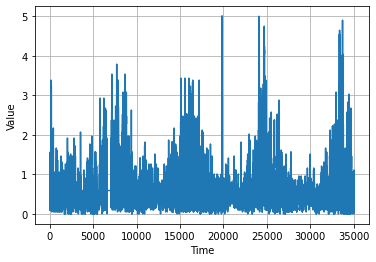

In [ ]:
series = np.array(CO_data, dtype=float)
time = np.arange(len(series))
plot_series(time, series)

Secara keseluruhan kita memiliki sekitar 35000 unit data. Kita kemudian pecah data ini dimana data-data terbaru akan digunakan sebagai validasi.

In [ ]:
def split(series, time, split_ratio):
    split_time = round(len(time) * (1-split_ratio))
    time_train = time[:split_time]
    x_train = series[:split_time]
    time_valid = time[split_time:]
    x_valid = series[split_time:]
    return (x_train, time_train), (x_valid, time_valid)

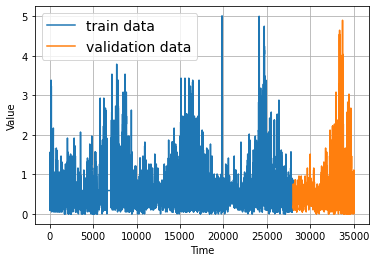

In [ ]:
train_data, validation_data = split(series, time, val_split)
plot_series(train_data[1], train_data[0], label ='train data')
plot_series(validation_data[1], validation_data[0], label='validation data')

Selanjutnya, kita akan konversi data array tersebut menjadi tensorflow Dataset dengan batch yang disesuaikan berdasarkan lebar jendela training yang akan dilakukan.

In [ ]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
train_set = sequential_window_dataset(train_data[0], window_size)
valid_set = sequential_window_dataset(validation_data[0], window_size)

## Membangun Model

Model yang akan dibangun adalah model Sequential berupa RNN yang stateful dengan sel LSTM.

Optimizer yang digunakan adalah Stochastic Gradient Descent dengan momentum.

In [ ]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_cell, return_sequences=True, stateful=True,
                              batch_input_shape=[1, None, 1]),
        tf.keras.layers.LSTM(num_cell, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 200.0)
    ])

    model.compile(
        loss = tf.keras.losses.Huber(),
        optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum),
        metrics = ["mae"]
    )

    return model

Selanjutnya, didefinisikan juga beberapa callbacks yang akan digunakan.

In [ ]:
def set_callbacks(model):
    callbacks = []
    CB = tf.keras.callbacks

    # no progress stopping callback
    impatient = CB.EarlyStopping(
        monitor = 'mae',
        patience = stopping_patience)
    callbacks.append(impatient)

    # stop when enough callback
    def stopper(epoch, logs):
        if logs['mae'] < success_threshold and logs['val_mae'] < success_threshold: 
            model.stop_training = True
    good_res = CB.LambdaCallback(on_epoch_end=lambda e,l: stopper(e,l))
    callbacks.append(good_res)

    # reset state of the model every epoch (because it will be a stateful rnn)                        
    reset_state = CB.LambdaCallback(on_epoch_begin=lambda e,l: model.reset_states())

    return callbacks

## Melatih Model!

Sekarang, saatnya membungkus semuanya

In [ ]:
model = build_model()

model.fit(
    train_set, 
    epochs = num_epoch,
    validation_data = valid_set,
    callbacks = set_callbacks(model)
)

Epoch 1/500
280/280 [==============================] - 12s 43ms/step - loss: 0.6515 - mae: 0.9502 - val_loss: 0.0731 - val_mae: 0.2478
Epoch 2/500
280/280 [==============================] - 11s 41ms/step - loss: 0.0604 - mae: 0.2397 - val_loss: 0.0630 - val_mae: 0.2260


Wow! Dalam 2 epoch MAE langsung mencapai batas kesuksesan yang ditetapkan (10 persen dari skala data).

Berati model kita sudah sangat bagus.

Sekarang saatnya kita cek hasilnya

In [ ]:
def forecast(model, series):
    time = np.arange(len(series))  
    split_time = round(len(time) * (1 - val_split))  
    res = model.predict(series[np.newaxis, :, np.newaxis])
    res = res[0, split_time - 1:-1, 0]
    return res

In [ ]:
model_forecast = forecast(model, series)

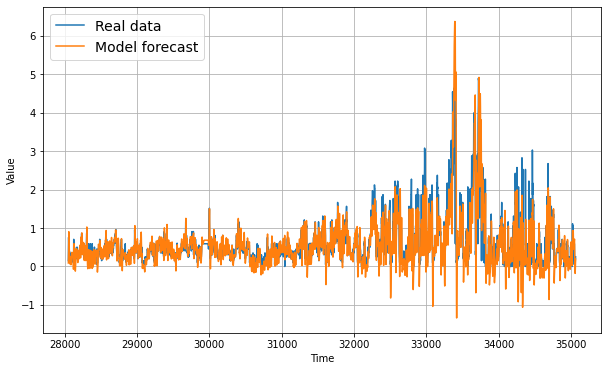

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(validation_data[1], validation_data[0], label='Real data')
plot_series(validation_data[1], model_forecast, label='Model forecast')